In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-10-27 17:40:34.435806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 17:40:34.439976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 17:40:34.440305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 2
VAL_BATCH_SIZE = 4

In [8]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [9]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [10]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [11]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [12]:
def configPerformance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [13]:
def preprocessA(img, lab, udFlipP, lrFlipP, hueD, contL, contH, brightD):
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, udFlipP)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, lrFlipP)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_hue(img, hueD) #Random +-
        img = tf.image.random_contrast(img, contL, contH) #Random Range contL to contH
        img = tf.image.random_brightness(img, brightD) #Random Brightness +- %
        
        return img, lab

In [14]:
def preprocessB(img, lab, rotL, rotH, shXL, shXH, shYL, shYH, zoomL, zoomH, hTransL, hTransH, vTransL, vTransH):
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    rRot = tf.random.uniform([shape[0]], minval=rotL, maxval=rotH, dtype=tf.float32)
    rShearX = tf.random.uniform([shape[0]], minval=shXL, maxval=shXH, dtype=tf.float32)
    rShearY = tf.random.uniform([shape[0]], minval=shYL, maxval=shYH, dtype=tf.float32)
    rZoom = tf.random.uniform([shape[0]], minval=zoomL, maxval=zoomH, dtype=tf.float32) #% Zoom
    rTx = tf.random.uniform([shape[0]], minval=hTransL, maxval=hTransH, dtype=tf.float32) #% Horiz Translation
    rTy = tf.random.uniform([shape[0]], minval=vTransL, maxval=vTransH, dtype=tf.float32) #% Vert Translation

    cT = tf.math.cos(rRot)
    sT = tf.math.sin(rRot)

    one = tf.ones([shape[0]], dtype=tf.float32)
    zero = tf.zeros([shape[0]], dtype=tf.float32)

    transC = tf.stack([[1, 0, -shapeF[2]/2], [0, 1, -shapeF[1]/2], [0, 0, 1]])
    transCI = tf.stack([[1, 0, shapeF[2]/2], [0, 1, shapeF[1]/2], [0, 0, 1]])

    trans = tf.transpose(tf.stack([[one, zero, rTx*shapeF[2]], [zero, one, rTy*shapeF[1]], [zero, zero, one]]), [2,0,1])
    rot = tf.transpose(tf.stack([[cT, -sT, zero], [sT, cT, zero], [zero, zero, one]]), [2,0,1])
    scale = tf.transpose(tf.stack([[rZoom, rShearX, zero], [rShearY, rZoom, zero], [zero, zero, one]]), [2,0,1])

    rotScale = rot@scale

    afTMat = transCI @ trans @ rotScale @ transC
    afT = tf.reshape(afTMat, [shape[0], -1])[:,:-1]

    img = tf.raw_ops.ImageProjectiveTransformV3(interpolation='NEAREST', images=img, transforms=afT, output_shape=shape[1:3], fill_value=0)

    return img, lab

In [15]:
def preprocessNoise(img, lab, gMean, gStd, spAmountP, spRatio, speckleVar):
        
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    # Gaussian Noise
    gNoise = tf.random.normal(shape, gMean, gStd)

    img += gNoise

    # Salt and pepper noise
    spMask = tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spAmountP), tf.float32)
    spNoise = 255*tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spRatio), tf.float32)

    img = tf.math.add(tf.math.multiply(img, 1.0 - spMask), tf.math.multiply(spNoise, spMask))

    # Speckles
    sNoise = speckleVar * tf.random.normal(shape)
    img = img + tf.math.multiply(img, sNoise)

    img = tf.clip_by_value(img, 0, 255)

    return img, lab

### Example Gen Parameters

With flips and noise

In [16]:
genParams = {
            "udFlipP": 0.5,
            "lrFlipP": 0.5,
            "hue": 0.3,
            "contrast": [0.95, 1.0],
            "brightness": 0.05,
            
            "rotation": [-math.pi, math.pi],
            "shearX": [-0.2, 0.2],
            "shearY": [-0.2, 0.2],
            
            "zoom": [0.8, 1.2], # +- 20%
            "hTranslation": [-0.2, 0.2], # +- 20%
            "vTranslation": [-0.2, 0.2], # +- 20%
            
            "gaussianMean": 0.0,
            "gaussianStd": 2.0,
            
            "spAmount": 0.0001,
            "spRatio": 0.5,
            
            "speckleVar": 0.01
        }

Without noise

In [17]:
genParams = {
            "udFlipP": 0.5,
            "lrFlipP": 0.5,
            "hue": 0.3,
            "contrast": [0.95, 1.0],
            "brightness": 0.05,
            
            "rotation": [-math.pi, math.pi],
            "shearX": [-0.2, 0.2],
            "shearY": [-0.2, 0.2],
            
            "zoom": [0.8, 1.2], # +- 20%
            "hTranslation": [-0.2, 0.2], # +- 20%
            "vTranslation": [-0.2, 0.2], # +- 20%
            
            "gaussianMean": 0.0,
            "gaussianStd": 0.0,
            
            "spAmount": 0.0,
            "spRatio": 0.0,
            
            "speckleVar": 0.0
        }

### Preprocessing Functions with Parameters

In [18]:
fA = partial(preprocessA, 
             udFlipP = genParams['udFlipP'],
             lrFlipP = genParams['lrFlipP'],
             hueD = genParams['hue'],
             contL = genParams['contrast'][0],
             contH = genParams['contrast'][1],
             brightD = genParams['brightness'])

In [19]:
fB = partial(preprocessB,
             rotL = genParams['rotation'][0],
             rotH = genParams['rotation'][1], 
             shXL = genParams['shearX'][0],
             shXH = genParams['shearX'][1], 
             shYL = genParams['shearY'][0],
             shYH = genParams['shearY'][1], 
             zoomL = genParams['zoom'][0],
             zoomH = genParams['zoom'][1],
             hTransL = genParams['hTranslation'][0], 
             hTransH = genParams['hTranslation'][1],
             vTransL = genParams['vTranslation'][0], 
             vTransH = genParams['vTranslation'][1])

In [20]:
fC = partial(preprocessNoise,
             gMean = genParams['gaussianMean'],
             gStd = genParams['gaussianStd'], 
             spAmountP = genParams['spAmount'],
             spRatio = genParams['spRatio'],
             speckleVar = genParams['speckleVar'])

In [21]:
preBatch = [("preprocessA", fA), ("preprocessC", fC)]
postBatch = [("preprocessB", fB)]

### Generate Dataset

In [22]:
ds = generateDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, configureDs=configPerformance, preBatch=preBatch, postBatch=postBatch)

2022-10-27 17:40:34.716358: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-27 17:40:34.717177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 17:40:34.717570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 17:40:34.717878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

### Example Dataset Usage

In [23]:
for x,y in ds.take(1):
    pass

2022-10-27 17:40:35.585011: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


<IPython.core.display.Javascript object>


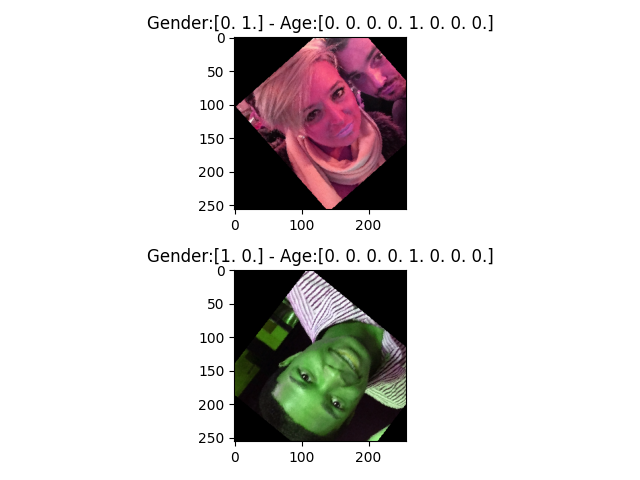

In [24]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y['gender'][i]} - Age:{y['age'][i]}")
        
plt.tight_layout()

### Generate Folds for K-Folds validation

In [25]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [26]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, trainConfigureDs=configPerformance, trainPreBatch=preBatch, trainPostBatch=postBatch)

In [27]:
len(folds)

5